# Single trace FWI sensitivity kernel example
1. generate forward modeled data in true model
1. generate forward modeled data in smooth model
1. backproject the residual (true - smooth) ... the fwi gradient

In [42]:
using PyPlot, Jets, WaveFD, JetPackWaveFD

In [43]:
v = read!("../02_marmousi_model_setup/marmousi_vp_20m_176x851.bin", Array{Float32}(undef, 176,851));
vₒ= read!("../02_marmousi_model_setup/marmousi_vp_smooth_20m_176x851.bin", Array{Float32}(undef, 176,851));
dz,dx = 20.0,20.0
nz,nx = size(v)
@show dz,dx
@show nz,nx;

(dz, dx) = (20.0, 20.0)
(nz, nx) = (176, 851)


In [44]:
F = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
    b = ones(Float32,size(v)),
    nthreads = Sys.CPU_THREADS,
    isinterior = true,
    nsponge = 80,
    ntrec = 3001,
    dtrec = 0.004,
    dtmod = 0.002,
    dz = dz,
    dx = dx,
    wavelet = WaveletCausalRicker(f=5.0),
    sx = dx*(100),
    sz = dz,
    rx = [dx*(nx-100)],
    rz = [dz])

"Jet nonlinear operator, (176, 851) → (3001, 1)"

In [45]:
v .= 1600
vₒ .= 1500
d = F*v;
dₒ = F*vₒ;

┌ Info: nonlinear forward on cbox-wask-D16s-v3, srcfieldfile=/scratch/field-8f6dcc61-556c-4f70-b13c-fe7f5deece26.bin
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:387
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step     1 of  6001 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%) -- rms d,p; 0.0000e+00 0.0000e+00
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:703
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step   500 of  6001 ;  111.29 MCells/s (IO=34.30%, EX=33.70%) -- rms d,p; 0.0000e+00 7.8127e-01
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:703
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  6001 ;  111.34 MCells/s (IO=33.66%, EX=33.18%) -- rms d,p; 0.0000e+00 5.6664e-01
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:703
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD,

In [46]:
r = d .- dₒ
J = jacobian(F, vₒ)
dv = J' * r;

┌ Info: linear adjoint on cbox-wask-D16s-v3, srcfieldfile=/scratch/field-8f6dcc61-556c-4f70-b13c-fe7f5deece26.bin
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:626
┌ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step     1 of  6001 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%, IM= 0.00%) -- rms d,p; 3.6672e-02 0.0000e+00
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:693
┌ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step     2 of  6001 ;    0.00 MCells/s (IO=43.58%, EX=14.00%, IM=25.75%) -- rms d,p; 3.6672e-02 0.0000e+00
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:693
┌ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step   502 of  6001 ;  151.83 MCells/s (IO=27.48%, EX=21.64%, IM=22.04%) -- rms d,p; 3.6672e-02 4.7843e-02
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:693
┌ Info: PropLn2DAcoIsoDenQ_DE

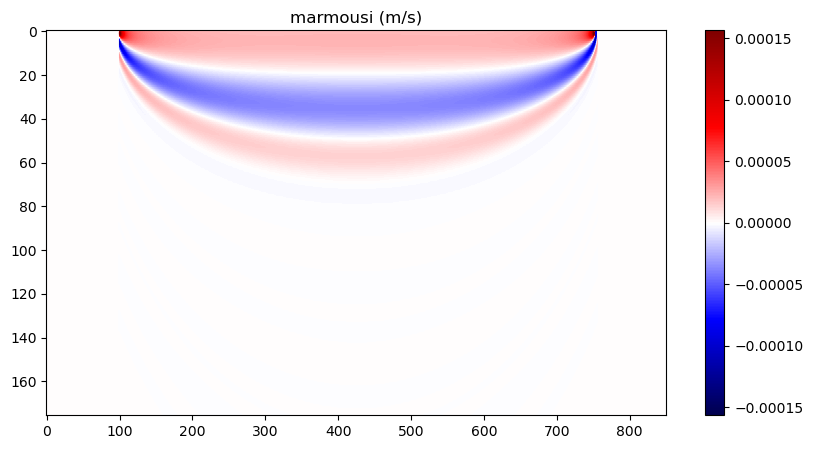

extrema(r) = (-0.68025225f0, 0.76650083f0)
extrema(dv) = (-0.00014485008f0, 0.00031324397f0)


In [47]:
@show extrema(r)
@show extrema(dv)
figure(figsize=(10,5))
dmax = maximum(abs,dv)
imshow(dv,aspect="auto", cmap="seismic", clim=0.5 .* [-dmax,dmax]);
colorbar();
title("marmousi (m/s)");